# Use examples of [edges](https://github.com/romainsacchi/edges)

Author: [romainsacchi](https://github.com/romainsacchi)

This notebook shows examples on how to use `edge` to use exchange-specific
characterization factors in the characterization matrix of `bw2calc`.

## Requirements

* **Pyhton 3.10 or higher (up to 3.11) is highly recommended**

# Use case with [brightway2](https://brightway.dev/)

`brightway2` is an open source LCA framework for Python.
To use `premise` from `brightway2`, it requires that you have an activated `brightway2` project with a `biosphere3` database as well as an [ecoinvent](https://ecoinvent.prg) v.3 cut-off or consequential database registered in that project. Please refer to the brightway [documentation](https://brightway.dev) if you do not know how to create a project and install ecoinvent.

## Example 1: simple biosphere-technosphere LCIA

In [1]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import bw2data

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


12:09:53+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


One can simply build its own LCIA file.
Let's consider the following LCIA file (saved under `lcia_example_1.json`):

In [2]:
method = {
  "name": "Example LCIA Method",
    "version": "1.0",
    "description": "Example LCIA method for greenhouse gas emissions",
    "unit": "kg CO2e",
    "strategies": [
        "map_exchanges"
    ],
  "exchanges": [
    {
      "supplier": {
        "name": "Carbon dioxide",
        "operator": "startswith",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": 1.0
    },
    {
      "supplier": {
        "name": "Methane, fossil",
        "operator": "contains",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": 28.0
    },
    {
      "supplier": {
        "name": "Dinitrogen monoxide",
        "operator": "equals",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": 265.0
    }
  ]
}

In [5]:
list(bw2data.projects)

[Project: ,
 Project: bw25_ei310,
 Project: default,
 Project: ecoinvent-migration,
 Project: ecoinvent-3.9.1-cutoff_bw25,
 Project: ecoinvent-3.9.11-cutoff,
 Project: aligned_bw25,
 Project: defult,
 Project: 66,
 Project: 74,
 Project: ecoinvent-3.9.1-cutoff,
 Project: ecoinvent-3.10-cutoff,
 Project: EdgeLCIA-Test,
 Project: EdgeLCC-Test,
 Project: ecoinvent-3.11-cutoff,
 Project: ecoinvent-3.11-EN15804,
 Project: ecoinvent-3.11-consequential,
 Project: ecoinvent-3.10-consequential,
 Project: ecoinvent-3.8-consequential,
 Project: ecoinvent-3.9.1-consequential,
 Project: ecoinvent-3.8-cutoff,
 Project: ecoinvent-3.11-cutoff-bw25,
 Project: ecoinvent-3.10.1-cutoff,
 Project: test_bw25,
 Project: test_bw2,
 Project: bw2,
 Project: bw25,
 Project: pLCA course,
 Project: pLCA course2,
 Project: pLCA course3,
 Project: pLCA course - premise,
 Project: some project,
 Project: test,
 Project: ecoinvent-3.10.1-consequential,
 Project: ecoinvent-3.11.-cutoff,
 Project: EdgeLCIA-Test-bw25]

In [6]:
# activate the bw project
#bw2data.projects.set_current("ecoinvent-3.11-cutoff")
bw2data.projects.set_current("ecoinvent-3.11-cutoff-bw25")
#act = bw2data.Database("ecoinvent-3.11-cutoff").random()
act = bw2data.Database("ecoinvent-3.11-cutoff").random()
act

'asparagus seedling production, for planting' (unit, FR, None)

In [7]:
LCA = EdgeLCIA(
    demand={act: 1},
    method=method,
)
LCA.lci()

LCA.apply_strategies()
#LCA.map_exchanges()

LCA.evaluate_cfs()
LCA.lcia()
LCA.score

No handlers could be found for logger "edges.edgelcia.EdgeLCIA"
Mapping exchanges: 100%|██████████████████████████| 3/3 [00:00<00:00, 48.86it/s]


0.010900385569700471

We can print some statistics:

In [8]:
LCA.statistics()

+----------------------+---------------------------------------------+
|       Activity       | asparagus seedling production, for planting |
|     Method name      |             Example LCIA Method             |
|         Unit         |                   kg CO2e                   |
|      Data file       |                                             |
|    CFs in method     |                      3                      |
|       CFs used       |                      3                      |
|   Unique CFs used    |                      3                      |
|  Exc. characterized  |                    14164                    |
| Exc. uncharacterized |                    387446                   |
+----------------------+---------------------------------------------+


### Generate dataframe of characterization factors used

The `generate_cf_table` method generates a dataframe of the characterization factors used in the calculation. One can see the characterization factors used for each exchange in the system.

In [9]:
df = LCA.generate_cf_table(include_unmatched=False)

In [10]:
# we can see under the "CF" column
# the characterization factors used for each exchange in the system
df

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
0,"Carbon dioxide, to soil or biomass stock","(soil, agricultural)",citric acid production,"protein feed, 100% crude",CN,2.444059e-38,1.0,2.444059e-38
1,"Carbon dioxide, to soil or biomass stock","(soil, agricultural)",burnt shale production,burnt shale,RoW,1.181003e-15,1.0,1.181003e-15
2,"Carbon dioxide, to soil or biomass stock","(soil, agricultural)",citric acid production,"energy feed, gross",RNA,4.790846e-40,1.0,4.790846e-40
3,"Carbon dioxide, to soil or biomass stock","(soil, agricultural)",citric acid production,citric acid,RoW,2.966282e-14,1.0,2.966282e-14
4,"Carbon dioxide, to soil or biomass stock","(soil, agricultural)","land already in use, annual cropland to perenn...","land tenure, arable land, measured as carbon n...",BR-PR,1.426570e-09,1.0,1.426570e-09
...,...,...,...,...,...,...,...,...
14159,Dinitrogen monoxide,"(air,)",three and five layered board production,"wood chips, dry, measured as dry mass",RER,1.862972e-13,265.0,4.936875e-11
14160,Dinitrogen monoxide,"(air,)","market for electricity, high voltage","electricity, high voltage",SS,7.679923e-14,265.0,2.035180e-11
14161,Dinitrogen monoxide,"(air,)","transport, freight, train, diesel","transport, freight, train, fleet average",RoW,4.215689e-10,265.0,1.117158e-07
14162,Dinitrogen monoxide,"(air,)","market for electricity, high voltage","electricity, high voltage",CA-PE,5.143206e-13,265.0,1.362949e-10


In [ ]:
df.groupby("supplier name")["CF"].mean()

## Example 2: biosphere-technosphere LCIA with parameters and scenarios

In this example, the evaluation of the CFs for `methane` and `dinitrogen monoxide` is a **symbolic expression depending on the value of the parameter `co2ppm`**. It is a simple approximation of the GWP100 factor of these gases as a function of the atmospheric CO₂ concentration.

In [11]:
method = {
  "name": "Example LCIA Method",
    "version": "1.0",
    "description": "Example LCIA method for greenhouse gas emissions",
    "unit": "kg CO2e",
    "exchanges": [
      {
        "supplier": {
          "name": "Carbon dioxide",
          "operator": "startswith",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
        },
        "value": "1.0"
      },
      {
        "supplier": {
          "name": "Methane, fossil",
          "operator": "contains",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
        },
        "value": "28 * (1 + 0.001 * (co2ppm - 410))"
      },
      {
        "supplier": {
          "name": "Dinitrogen monoxide",
          "operator": "equals",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
        },
        "value": "265 * (1 + 0.0005 * (co2ppm - 410))"
      }
  ]
}

In [12]:
import bw2data
from edges import EdgeLCIA

# Select an activity from the LCA database
#bw2data.projects.set_current("ecoinvent-3.11-cutoff")
bw2data.projects.set_current("ecoinvent-3.11-cutoff-bw25")
act = bw2data.Database("ecoinvent-3.11-cutoff").random()
print(act)

# Define scenario parameters (e.g., atmospheric CO₂ concentration and time horizon)
params = {
    "some scenario": {
         "co2ppm": {
             "2020": 410,
             "2050": 450,
             "2100": 500},
        "h": {
            "2020": 100,
            "2050": 100,
            "2100": 100
        }
    }
}

# Initialize LCIA
lcia = EdgeLCIA(
   demand={act: 1},
   method=method,
   parameters=params
)

# Perform inventory calculations (once)
lcia.lci()

# Map exchanges to CF entries (once)
lcia.map_exchanges()


# Run scenarios efficiently
results = []
for idx in {"2020", "2050", "2100"}:
    lcia.evaluate_cfs(idx)
    lcia.lcia()
    #df = lcia.generate_cf_table()

    #scenario_result = {
    #    "scenario": idx,
    #    "co2ppm": params["some scenario"]["co2ppm"][idx],
    #    "score": lcia.score,
    #    "CF_table": df
    #}
    #results.append(scenario_result)

    print(f"Scenario (CO₂ {params['some scenario']['co2ppm'][idx]} ppm): Impact = {lcia.score}")

'market for sodium chloride, brine solution' (kilogram, GLO, None)


Mapping exchanges: 100%|██████████████████████████| 3/3 [00:00<00:00, 60.56it/s]

Scenario (CO₂ 500 ppm): Impact = 0.14181204778340525
Scenario (CO₂ 410 ppm): Impact = 0.14108463192229004
Scenario (CO₂ 450 ppm): Impact = 0.14140792786056344


## Example 3: biosphere-technosphere LCIA with function call

In this example, the evaluation of the CFs for `methane` and `dinitrogen monoxide` is returned by a call to an external function `GWP`.

We first create a function that will claculate the GWP of a given over a given tine horizon.
Inspired from the IPCC AR5, 2021.

In [13]:
import numpy as np
# Physical constants
M_atm = 5.15e18  # kg, total mass of Earth's atmosphere
M_air = 28.96    # g/mol, average molar mass of air

# Gas-specific molecular weights (g/mol)
M_gas = {
    'CO2': 44.01,
    'CH4': 16.04,
    'N2O': 44.013
}

# IPCC concentration parameters (Myhre et al. 1998 / IPCC AR6)
RF_COEFF = {
    'CH4': 0.036,  # W·m⁻²·ppb⁻½ for CH4
    'N2O': 0.12    # W·m⁻²·ppb⁻½ for N2O
}

# Reference atmospheric concentrations (IPCC AR6, ~2019)
C_REF = {
    'CH4': 1866,  # ppb
    'N2O': 332    # ppb
}

# Indirect forcing factor for methane (IPCC AR6)
INDIRECT_FACTOR = {
    'CH4': 1.65,
    'N2O': 1.0
}

# Gas-specific atmospheric lifetimes (years, IPCC AR6)
TAU_GAS = {
    'CH4': 11.8,
    'N2O': 109
}

# CO2 impulse response function parameters (IPCC AR5/AR6)
CO2_IRF = {
    'a0': 0.2173,
    'a': [0.2240, 0.2824, 0.2763],
    'tau': [394.4, 36.54, 4.304]
}

# Convert concentration-based radiative efficiency to mass-based (W·m⁻²·kg⁻¹)
def convert_ppb_to_mass_rf(a_ppb, gas):
    return a_ppb * (M_atm / M_gas[gas]) * (M_air / 1e9)

# Calculate concentration-dependent radiative efficiency
def radiative_efficiency_concentration(gas, concentration_ppb):
    alpha = RF_COEFF[gas]
    return (alpha / (2 * np.sqrt(concentration_ppb))) * INDIRECT_FACTOR[gas]

# AGWP for CO2 (mass-based)
def AGWP_CO2(H):
    integral_CO2 = CO2_IRF['a0'] * H + sum(
        a * tau * (1 - np.exp(-H / tau))
        for a, tau in zip(CO2_IRF['a'], CO2_IRF['tau'])
    )
    am_CO2 = convert_ppb_to_mass_rf(1.37e-5, 'CO2')  # fixed IPCC radiative efficiency for CO2
    return am_CO2 * integral_CO2

# AGWP for gas at given concentration
def AGWP_gas(gas, H, concentration_ppb):
    aa_gas = radiative_efficiency_concentration(gas, concentration_ppb)
    am_gas = convert_ppb_to_mass_rf(aa_gas, gas)
    tau_gas = TAU_GAS[gas]
    return am_gas * tau_gas * (1 - np.exp(-H / tau_gas))

# Calculate concentration-dependent GWP
def GWP(gas, H, concentration_ppb):
    AGWP_g = AGWP_gas(gas, H, concentration_ppb)
    AGWP_ref = AGWP_CO2(H)
    return AGWP_g / AGWP_ref


In [14]:
GWP('CH4', 100, 1911)

30.660731597024444

In [15]:
method = {
  "name": [
    "Parameterized GWP method"
  ],
  "unit": "kg CO2-eq",
  "description": "Parameterized GWP factors.",
  "version": "1.0",
  "exchanges": [
    {
      "supplier": {
        "name": "Carbon dioxide",
        "operator": "startswith",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": "1.0"
    },
    {
        "supplier": {
          "name": "Methane, fossil",
          "operator": "contains",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
        },
        "value": "GWP('CH4',H, C_CH4)"
      },
    {
      "supplier": {
        "name": "Dinitrogen monoxide",
        "operator": "equals",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": "GWP('N2O',H, C_N2O)"
    }
  ],
  "scenarios": {
    "RCP1.9": {
      "C_CH4": {
        "2020": 1866,
        "2050": 1428,
        "2080": 1150,
        "2100": 1036
      },
      "C_N2O": {
        "2020": 332,
        "2050": 344,
        "2080": 350,
        "2100": 354
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    },
    "RCP2.6": {
      "C_CH4": {
        "2020": 1866,
        "2050": 1519,
        "2080": 1197,
        "2100": 1056
      },
      "C_N2O": {
        "2020": 332,
        "2050": 344,
        "2080": 349,
        "2100": 354
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    },
    "RCP4.5": {
      "C_CH4": {
        "2020": 1866,
        "2050": 2020,
        "2080": 1779,
        "2100": 1683
      },
      "C_N2O": {
        "2020": 332,
        "2050": 356,
        "2080": 373,
        "2100": 377
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    },
    "RCP8.5": {
      "C_CH4": {
        "2020": 1866,
        "2050": 2446,
        "2080": 2652,
        "2100": 2415
      },
      "C_N2O": {
        "2020": 332,
        "2050": 358,
        "2080": 380,
        "2100": 392
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    }
  }
}



In [16]:
# we declare the function
allowed_funcs = {"GWP": GWP}

In [17]:
all_results = []  # To collect results

# Initialize LCIA
lcia = EdgeLCIA(
    demand={act: 1},
    method=method,
    allowed_functions=allowed_funcs # we declare the functions to call.
)

# Usual LCIA steps
lcia.lci()
lcia.map_exchanges()

results = []
# Loop over scenarios
for scenario in [
    "RCP1.9",
    "RCP2.6",
    "RCP4.5",
    "RCP8.5",
]:
    for year in [
        "2020",
        "2050",
        "2080",
        "2100",
    ]:
        print(scenario, year)
        lcia.evaluate_cfs(scenario=scenario, scenario_idx=year)
        lcia.lcia()
        # df = lcia.generate_cf_table()

        #scenario_result = {
        #    "year": int(year),
        #    "rcp": scenario,
        #    "score": lcia.score,
        #    "CF_table": df
        #}
        #all_results.append(scenario_result)

        print(f"Year {year} | {scenario}: Impact = {lcia.score}")

Mapping exchanges: 100%|██████████████████████████| 3/3 [00:00<00:00, 60.02it/s]


RCP1.9 2020
Year 2020 | RCP1.9: Impact = 0.1420363083546999
RCP1.9 2050
Year 2050 | RCP1.9: Impact = 0.14322159992643693
RCP1.9 2080
Year 2080 | RCP1.9: Impact = 0.14431240476560853
RCP1.9 2100
Year 2100 | RCP1.9: Impact = 0.14488085720289692
RCP2.6 2020
Year 2020 | RCP2.6: Impact = 0.1420363083546999
RCP2.6 2050
Year 2050 | RCP2.6: Impact = 0.14292892789563139
RCP2.6 2080
Year 2080 | RCP2.6: Impact = 0.14410133064457287
RCP2.6 2100
Year 2100 | RCP2.6: Impact = 0.14477336836025412
RCP4.5 2020
Year 2020 | RCP4.5: Impact = 0.1420363083546999
RCP4.5 2050
Year 2050 | RCP4.5: Impact = 0.14167125340859313
RCP4.5 2080
Year 2080 | RCP4.5: Impact = 0.14217728442623528
RCP4.5 2100
Year 2100 | RCP4.5: Impact = 0.14241420897450996
RCP8.5 2020
Year 2020 | RCP8.5: Impact = 0.1420363083546999
RCP8.5 2050
Year 2050 | RCP8.5: Impact = 0.14093009229768952
RCP8.5 2080
Year 2080 | RCP8.5: Impact = 0.14060756909818567
RCP8.5 2100
Year 2100 | RCP8.5: Impact = 0.1409300157659693


## Example 5: biosphere-technosphere LCIA with geographies and uncertainty

In this example, we try to characterize water withdrawals, and uncertainty information.

In [18]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import bw2data

In [28]:
method = {
  "name": "Example LCIA Method",
    "version": "1.0",
    "description": "Example LCIA method for water withdrawals",
    "unit": "m3 freshwater",
    "strategies": [
        "map_exchanges",
        "map_contained_locations"
    ],
  "exchanges": [
    {
         "supplier": {
            "name": "Water",
            "matrix": "biosphere"
         },
         "consumer": {
            "location": "RER",
            "matrix": "technosphere",
         },
         "value": 17,
         "weight": 213938000,
         "uncertainty": {
            "distribution": "discrete_empirical",
            "parameters": {
               "values": [
                  6.87,
                  7.56,
                  13.4,
                  15.5,
                  18.7,
                  19.1,
                  21.5,
                  21.8,
                  27.6,
                  29.8,
                  31.0,
                  33.5,
                  33.7,
                  34.6
               ],
               "weights": [
                  0.153,
                  0.324,
                  0.015,
                  0.038,
                  0.079,
                  0.008,
                  0.0,
                  0.075,
                  0.074,
                  0.0,
                  0.008,
                  0.013,
                  0.08,
                  0.131
               ]
            }
         }
      },
      {
         "supplier": {
            "name": "Water",
            "matrix": "biosphere"
         },
         "consumer": {
            "location": "FR",
            "matrix": "technosphere",
            "classifications": {
               "CPC": [
                  "01"
               ]
            }
         },
         "value": 10,
         "weight": 213938000,
         "uncertainty": {
            "distribution": "triang",
            "parameters": {
               "loc": 11,
               "minimum": 0.752,
               "maximum": 50.6
            }
         }
      }
  ]
}

In [29]:
# bw2data.projects.set_current("ecoinvent-3.11-cutoff-bw25")
bw2data.projects.set_current("ecoinvent-3.11-cutoff-bw25")
act = bw2data.Database("ecoinvent-3.11-cutoff").random()
act

'heat and power co-generation, biogas, gas engine' (kilowatt hour, PT, None)

In [30]:
LCA = EdgeLCIA(
    demand={act: 1},
    method=method,
    weight="population"
)
LCA.lci()

LCA.apply_strategies()
#LCA.map_exchanges()


LCA.evaluate_cfs()
LCA.lcia()
LCA.score

Processing contained groups (pass 1): 100%|███████| 1/1 [00:00<00:00,  1.15it/s]


0.5299473989875972

In [35]:
df = LCA.generate_cf_table(include_unmatched=True)

In [37]:
df

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
0,Water,"(water, ground-)",rye production,rye grain,RER,8.595840e-11,17.0,1.461293e-09
1,Water,"(water, ground-)",rye production,straw,RER,2.133934e-09,17.0,3.627687e-08
2,Water,"(water, ground-)","sodium perborate production, tetrahydrate, powder","sodium perborate, tetrahydrate, powder",RER,1.076381e-13,17.0,1.829848e-12
3,Water,"(water, ground-)",liquid packaging board production,"tall oil, crude",RER,8.182073e-14,17.0,1.390952e-12
4,Water,"(water, ground-)",citric acid production,citric acid,RER,6.327271e-12,17.0,1.075636e-10
...,...,...,...,...,...,...,...,...
401564,Carfentrazone-ethyl,"(soil, agricultural)",anthraquinone production,anthraquinone,RER,1.366859e-20,NaN,NaN
401565,Selenium IV,"(air, urban air close to ground)",citric acid production,"protein feed, 100% crude",CN,5.816692e-40,NaN,NaN
401566,Copper ion,"(water, ground-)",rape seed production,rape seed,US,8.016205e-17,NaN,NaN
401567,Simazine,"(water, ground-)","sodium percarbonate production, powder","sodium percarbonate, powder",RER,4.943387e-22,NaN,NaN


In [33]:
df.groupby("consumer location")["CF"].unique()

consumer location
AT                                              [17.0]
BA                                              [17.0]
BE                                              [17.0]
BG                                              [17.0]
CH                                              [17.0]
CZ                                              [17.0]
DE                                              [17.0]
DK                                              [17.0]
EE                                              [17.0]
ES                                              [17.0]
Europe without Austria                          [17.0]
Europe without Switzerland                      [17.0]
Europe without Switzerland and Austria          [17.0]
FI                                              [17.0]
FR                                        [10.0, 17.0]
GB                                              [17.0]
GR                                              [17.0]
HR                                             

In [34]:
df.loc[
    (df["consumer location"] == "FR")
]

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
1218,Water,"(water, ground-)",sunflower production,sunflower seed,FR,4.917481e-44,10.0,4.917481e-43
1219,Water,"(water, ground-)",rape seed production,rape seed,FR,4.786442e-12,10.0,4.786442e-11
1220,Water,"(water, ground-)",barley grain production,barley grain,FR,1.043281e-26,10.0,1.043281e-25
1221,Water,"(water, ground-)",wheat grain production,wheat grain,FR,1.116207e-14,10.0,1.116207e-13
1222,Water,"(water, ground-)",sugar beet production,sugar beet,FR,1.437880e-16,10.0,1.437880e-15
...,...,...,...,...,...,...,...,...
2929,Water,"(air,)","electricity production, oil","electricity, high voltage",FR,6.936814e-09,17.0,1.179258e-07
2930,Water,"(water,)","treatment of used vegetable cooking oil, purif...",fatty acid methyl ester,FR,3.712019e-15,17.0,6.310433e-14
2931,Water,"(water,)","electricity production, hydro, pumped storage","electricity, high voltage",FR,9.333025e-06,17.0,1.586614e-04
2932,Water,"(air,)","electricity production, photovoltaic, 570kWp o...","electricity, low voltage",FR,1.034653e-14,17.0,1.758911e-13


In [39]:
act = [x for x in bw2data.Database("ecoinvent-3.11-cutoff") if x['location']=='FR' and "electricity production, hydro" in x["name"]][0]
print(act)
LCA = EdgeLCIA(
    demand={act: 1},
    method=method,
    use_distributions=True,
    iterations=10_000
)
LCA.lci()

LCA.apply_strategies()
#LCA.map_exchanges()

LCA.evaluate_cfs()
LCA.lcia()
LCA.score

'electricity production, hydro, run-of-river' (kilowatt hour, FR, None)


Processing contained groups (pass 1): 100%|███████| 1/1 [00:00<00:00,  1.16it/s]


Format,coo
Data Type,float64
Shape,"(10000,)"
nnz,10000
Density,1.0
Read-only,True
Size,156.2K
Storage ratio,2.00


In [40]:
type(LCA.score.data)

numpy.ndarray

(array([1541., 3237.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  157.,    0.,    0.,    0.,  383.,    0.,    0.,
           0.,    0.,    0.,  791.,   85.,    0.,    0.,    0.,  766.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  718.,    0.,    0.,    0.,    0.,    0.,   64.,    0.,
           0.,    0.,    0.,  967., 1291.]),
 array([ 309.18400933,  334.14375483,  359.10350033,  384.06324583,
         409.02299133,  433.98273683,  458.94248232,  483.90222782,
         508.86197332,  533.82171882,  558.78146432,  583.74120982,
         608.70095532,  633.66070082,  658.62044631,  683.58019181,
         708.53993731,  733.49968281,  758.45942831,  783.41917381,
         808.37891931,  833.3386648 ,  858.2984103 ,  883.2581558 ,
         908.2179013 ,  933.1776468 ,  958.1373923 ,  983.0971378 ,
        1008.0568833 , 1033.01662879, 1057.97637429, 1082.93611979,
        1107.89586529, 1132.85561079, 1157.81535629, 118

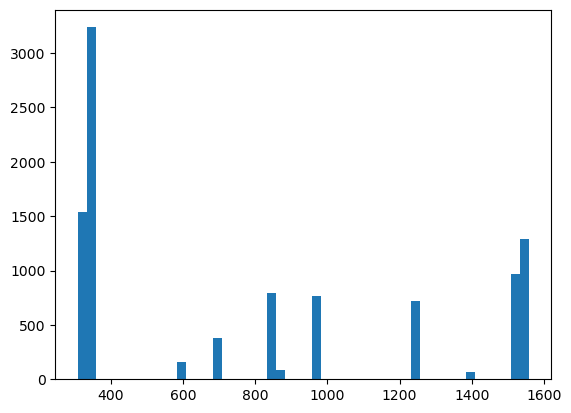

In [41]:
import matplotlib.pyplot as plt
plt.hist(LCA.score.data, bins=50)

In [42]:
df = LCA.generate_cf_table()

In [43]:
df

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF (mean),CF (std),CF (min),CF (5th),...,CF (max),impact (mean),impact (std),impact (min),impact (5th),impact (25th),impact (50th),impact (75th),impact (95th),impact (max)
0,Water,"(water, ground-)","treatment of sewage sludge, 97% water, WWT, WW...","sewage sludge, 97% water, WWT, WW from ceramic...",CH,5.421531e-20,17.523819,11.085148,6.87000,6.870000,...,34.600000,9.500593e-19,6.009847e-19,3.724592e-19,3.724592e-19,4.098678e-19,8.403373e-19,1.496343e-18,1.875850e-18,1.875850e-18
1,Water,"(water, ground-)","treatment of sewage sludge, 97% water, WWT, he...","sewage sludge, 97% water, WWT, heat carrier li...",CH,5.964970e-16,17.523819,11.085148,6.87000,6.870000,...,34.600000,1.045291e-14,6.612257e-15,4.097934e-15,4.097934e-15,4.509517e-15,9.245704e-15,1.646332e-14,2.063880e-14,2.063880e-14
2,Water,"(water, ground-)",sunflower production,sunflower seed,FR,1.772559e-45,20.888070,10.712799,0.90071,5.873434,...,50.382686,3.702534e-44,1.898907e-44,1.596562e-45,1.041101e-44,2.176593e-44,3.431239e-44,5.033502e-44,7.210725e-44,8.930629e-44
3,Water,"(water, ground-)","treatment of sewage sludge, 97% water, WWT-SLF...","sewage sludge, 97% water, WWT-SLF, waste paint",Europe without Switzerland,1.313111e-15,17.523819,11.085148,6.87000,6.870000,...,34.600000,2.301073e-14,1.455603e-14,9.021076e-15,9.021076e-15,9.927122e-15,2.035323e-14,3.624188e-14,4.543366e-14,4.543366e-14
4,Water,"(water, ground-)","grass production, permanent grassland, Swiss i...","grass, Swiss integrated production",CH,6.669004e-27,17.523819,11.085148,6.87000,6.870000,...,34.600000,1.168664e-25,7.392689e-26,4.581606e-26,4.581606e-26,5.041767e-26,1.033696e-25,1.840645e-25,2.307475e-25,2.307475e-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,Water,"(air, urban air close to ground)","treatment of municipal solid waste, municipal ...",municipal solid waste,EE,6.244929e-13,17.523819,11.085148,6.87000,6.870000,...,34.600000,1.094350e-11,6.922596e-12,4.290266e-12,4.290266e-12,4.721166e-12,9.679640e-12,1.723600e-11,2.160745e-11,2.160745e-11
3449,Water,"(air, urban air close to ground)",latex production,latex,RER,3.505082e-16,17.523819,11.085148,6.87000,6.870000,...,34.600000,6.142243e-15,3.885436e-15,2.407992e-15,2.407992e-15,2.649842e-15,5.432878e-15,9.674027e-15,1.212759e-14,1.212759e-14
3450,Water,"(air, urban air close to ground)","treatment of leachate, SLF, municipal solid wa...","leachate, SLF, municipal solid waste",LT,1.301531e-16,17.523819,11.085148,6.87000,6.870000,...,34.600000,2.280779e-15,1.442766e-15,8.941515e-16,8.941515e-16,9.839571e-16,2.017372e-15,3.592224e-15,4.503296e-15,4.503296e-15
3451,Water,"(air, urban air close to ground)","steel production, electric, low-alloyed","steel, low-alloyed",CH,4.185877e-09,17.523819,11.085148,6.87000,6.870000,...,34.600000,7.335256e-08,4.640107e-08,2.875698e-08,2.875698e-08,3.164523e-08,6.488110e-08,1.155302e-07,1.448314e-07,1.448314e-07


### Bonus: Sankey diagram

In [44]:
from edges import SupplyChain

In [45]:
sc = SupplyChain(
    activity=act,
    method=method,
    amount=1,
    level=8,
    cutoff=0.01,
    cutoff_basis="total",
    collapse_markets=False,
)
total = sc.bootstrap()
df, total_score, ref_amount = sc.calculate()

sc.save_html(
    df,
    path="example_sankey.html",
    height_max=1000,
    width_max=2400,
    node_instance_mode="by_parent",  # or "by_child_level" / "by_level"
    node_thickness=12
)

Processing contained groups (pass 1): 100%|███████| 1/1 [00:00<00:00,  1.14it/s]


'example_sankey.html'

## Example 6: technosphere-technosphere LCIA

In this example, we want to characterize intermediate product exchanges.
Here, we are interested in the amount of **secondary copper** flowing in the system.

In [46]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import bw2data

In [47]:
method = {
  "name": "ecoinvent 3.10/3.11 - RELICS - Copper, secondary",
  "unit": "kg",
  "version": "1.0",
  "strategies": [
       "map_exchanges"
   ],
  "exchanges": [
    {
      "supplier": {
        "name": "treatment of",
        "reference product": "copper, cathode",
        "operator": "startswith",
        "matrix": "technosphere",
        "excludes": [
          "market"
        ]
      },
      "consumer": {
        "matrix": "technosphere"
      },
      "value": 1.0
    },
    {
        "supplier": {
          "name": "treatment of",
          "reference product": "copper, anode",
          "operator": "startswith",
          "matrix": "technosphere",
          "excludes": [
            "market",
            "slime"
          ]
        },
        "consumer": {
          "matrix": "technosphere"
        },
        "value": 1.0
      }
  ]
}

In [48]:
bw2data.projects.set_current("ecoinvent-3.11-cutoff-bw25")
act = bw2data.Database("ecoinvent-3.11-cutoff").random()
act

'electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted' (kilowatt hour, GB, None)

In [49]:
LCA = EdgeLCIA(
    demand={act: 1000},
    method=method,
)
LCA.lci()

LCA.apply_strategies()
#LCA.map_exchanges()

LCA.evaluate_cfs()
LCA.lcia()
LCA.score

Mapping exchanges: 100%|█████████████████████████| 2/2 [00:00<00:00, 218.72it/s]


0.08206826370271944

In [50]:
df = LCA.generate_cf_table()

In [51]:
df

,supplier name,supplier reference product,supplier location,consumer name,consumer reference product,consumer location,amount,CF,impact
0,treatment of copper scrap by electrolytic refi...,"copper, cathode",RoW,"market for copper, cathode","copper, cathode",GLO,6.188761e-02,1.0,6.188761e-02
1,treatment of copper cake,"copper, cathode",GLO,"market for copper, cathode","copper, cathode",GLO,9.059114e-04,1.0,9.059114e-04
2,"treatment of non-Fe-Co-metals, from used Li-io...","copper, cathode",GLO,"market for copper, cathode","copper, cathode",GLO,3.840415e-07,1.0,3.840415e-07
3,treatment of copper scrap by electrolytic refi...,"copper, cathode",RER,"market for copper, cathode","copper, cathode",GLO,1.401748e-02,1.0,1.401748e-02
4,"treatment of metal part of electronics scrap, ...","copper, cathode",RoW,"market for copper, cathode","copper, cathode",GLO,3.459969e-04,1.0,3.459969e-04
5,"treatment of non-Fe-Co-metals, from used Li-io...","copper, cathode",GLO,"market for copper, cathode","copper, cathode",GLO,8.778045e-07,1.0,8.778045e-07
6,"treatment of metal part of electronics scrap, ...","copper, cathode",SE,"market for copper, cathode","copper, cathode",GLO,9.171338e-07,1.0,9.171338e-07
7,treatment of used cable,"copper, cathode",GLO,"market for copper, cathode","copper, cathode",GLO,4.909085e-03,1.0,4.909085e-03
